# Testing 

In [12]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
import os
import stan_utility
import corner
import astropy.units as u
%load_ext autoreload
%autoreload 2
#%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Sources

In [21]:
from python.source.parameter import Parameter
from python.source.source import Sources, PointSource

In [22]:
# define high-level parameters
Parameter.clear_registry()
index = Parameter(2.2, "index", fixed=False, par_range=(1.0, 4))
L = Parameter(3E47 * (u.erg / u.s), "luminosity", fixed=True, par_range=(0, 1E60))
diffuse_norm = Parameter(2e-13 /u.GeV/u.m**2/u.s, "diffuse_norm", fixed=True, 
                         par_range=(0, np.inf))
Enorm = Parameter(1E5 * u.GeV, "Enorm", fixed=True)
Emin = Parameter(5E4 * u.GeV, "Emin", fixed=True)
Emax = Parameter(1E8 * u.GeV, "Emax", fixed=True)
#Emin_det = Parameter(1E5 * u.GeV, "Emin_det", fixed=True)

Emin_det_tracks = Parameter(1e5 * u.GeV, "Emin_det_tracks", fixed=True)
Emin_det_cascades = Parameter(6e4 * u.GeV, "Emin_det_cascades", fixed=True)

# Single PS for testing and usual components
point_source = PointSource.make_powerlaw_source("test", np.deg2rad(5)*u.rad,
                                                np.pi*u.rad, 
                                                L, index, 0.43, Emin, Emax)

# Multiple sources from file
#source_file = "../dev/statistical_model/data/test_SFR_pop.h5"
#point_sources = PointSource.make_powerlaw_sources_from_file(source_file, L, 
#                                                            index, Emin, Emax)

my_sources = Sources()
#my_sources.add(point_sources)
#my_sources.select_below_redshift(0.8)
my_sources.add(point_source)

my_sources.add_diffuse_component(diffuse_norm, Enorm.value) # auto diffuse component 
my_sources.add_atmospheric_component() # auto atmo component

In [23]:
my_sources.associated_fraction()

<Quantity 0.06658911>

## Simulation

In [24]:
from python.simulation import Simulation
from python.detector.cascades import CascadesDetectorModel 
from python.detector.northern_tracks import NorthernTracksDetectorModel
from python.detector.icecube import IceCubeDetectorModel

In [25]:
obs_time = 10 * u.year
#sim = Simulation(my_sources, CascadesDetectorModel, obs_time)
#sim = Simulation(my_sources, NorthernTracksDetectorModel, obs_time)
sim = Simulation(my_sources, IceCubeDetectorModel, obs_time)

In [26]:
sim.precomputation()
sim.generate_stan_code()
sim.compile_stan_code()
sim.run(verbose=True, seed=42)
sim.save("output/test_sim_file.h5")

INFO:cmdstanpy:compiling stan program, exe file: /Users/fran/projects/hierarchical_nu/software/stan_files/atmo_gen
INFO:cmdstanpy:compiler options: stanc_options={'include_paths': ['/Users/fran/projects/hierarchical_nu/software/stan_files']}, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/fran/projects/hierarchical_nu/software/stan_files/atmo_gen
INFO:cmdstanpy:compiling stan program, exe file: /Users/fran/projects/hierarchical_nu/software/stan_files/sim_code
INFO:cmdstanpy:compiler options: stanc_options={'include_paths': ['/Users/fran/projects/hierarchical_nu/software/stan_files']}, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/fran/projects/hierarchical_nu/software/stan_files/sim_code
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


Running a simulation with expected Nnu = 64.14 events


INFO:cmdstanpy:finish chain 1


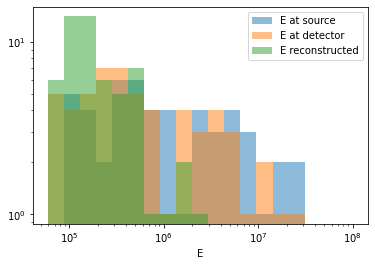

In [27]:
fig, ax = sim.show_spectrum()

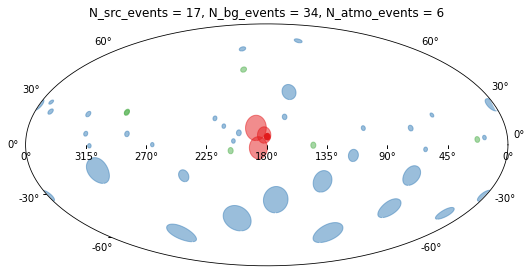

In [28]:
fig, ax = sim.show_skymap()

## Fit 

In [29]:
from python.events import Events
from python.fit import StanFit
from python.detector.northern_tracks import NorthernTracksDetectorModel
from python.detector.cascades import CascadesDetectorModel
from python.detector.icecube import IceCubeDetectorModel

In [30]:
events = Events.from_file("output/test_sim_file.h5")
obs_time = 10 * u.year

In [31]:
#fit = StanFit(my_sources, CascadesDetectorModel, events, obs_time)
#fit = StanFit(my_sources, NorthernTracksDetectorModel, events, obs_time)
fit = StanFit(my_sources, IceCubeDetectorModel, events, obs_time)

In [32]:
fit.precomputation()
fit.generate_stan_code()
fit.compile_stan_code()
fit.run(show_progress=True, seed=42)

INFO:cmdstanpy:compiling stan program, exe file: /Users/fran/projects/hierarchical_nu/software/stan_files/model_code
INFO:cmdstanpy:compiler options: stanc_options={'include_paths': ['/Users/fran/projects/hierarchical_nu/software/stan_files']}, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/fran/projects/hierarchical_nu/software/stan_files/model_code
Chain 1 -   done: 100%|██████████| 2000/2000 [04:06<00:00,  8.10it/s]


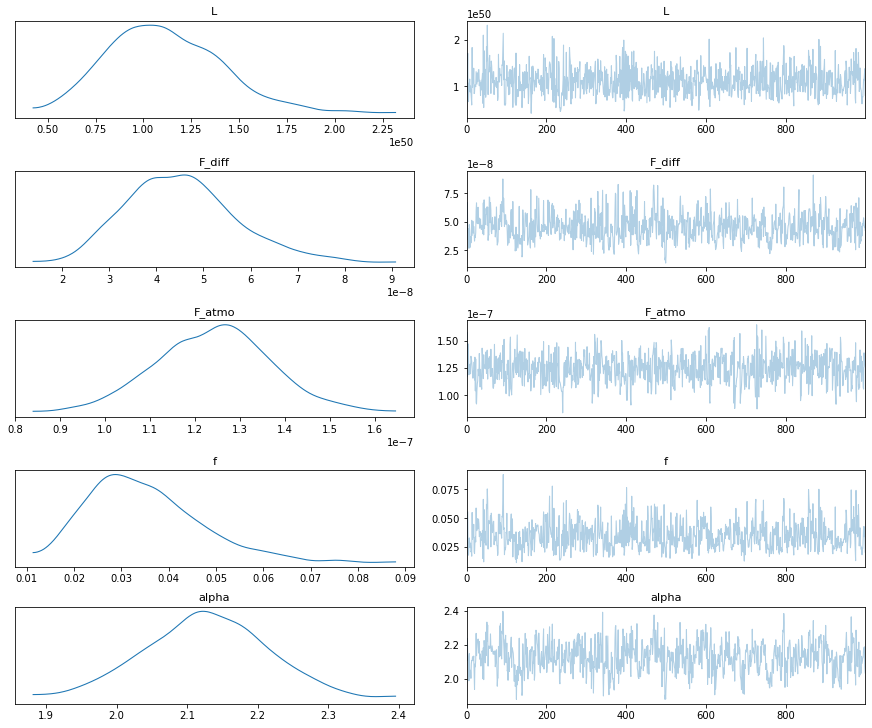

In [33]:
fit.plot_trace()

In [34]:
fit.save("output/test_fit_file.h5")

We can check the results of the fit against the known true values from the above simulation.

In [35]:
from python.simulation import SimInfo

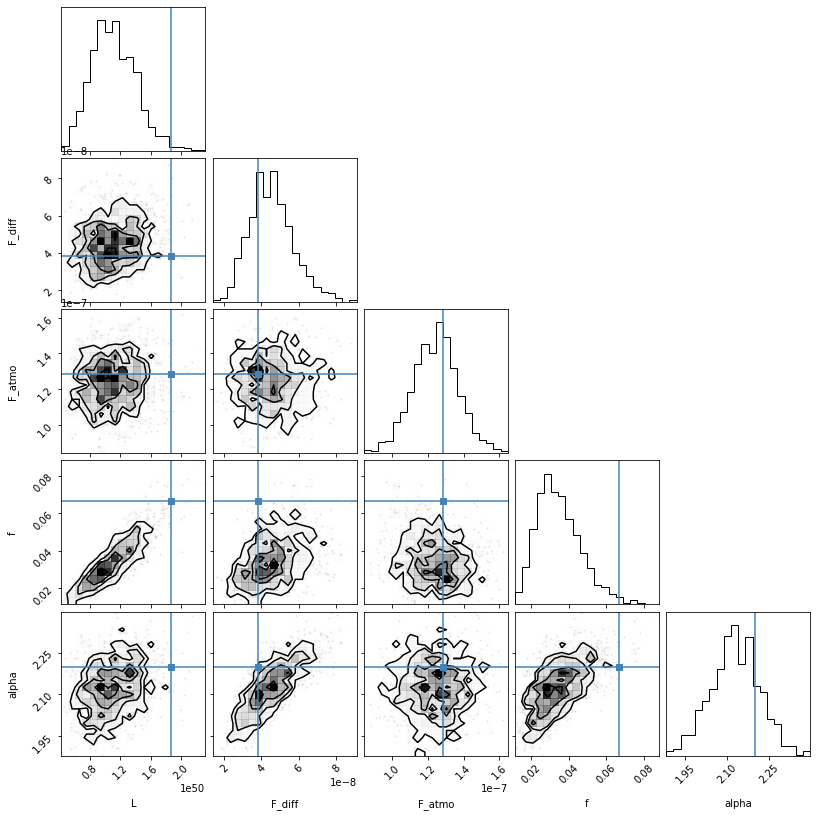

In [36]:
sim_info = SimInfo.from_file("output/test_sim_file.h5")
fig = fit.corner_plot(truths=sim_info.truths)

Similarly, we can use the simulation info to check the classification of individual events. We shouldn't be concerned if things are slighty off, particularly between the two background components. 

In [37]:
fit.check_classification(sim_info.outputs)

Event 0 is misclassified
P(src0) = 0.000000
P(diff) = 0.951012
P(atmo) = 0.048988
The correct component is atmo

Event 4 is misclassified
P(src0) = 0.000000
P(diff) = 0.895674
P(atmo) = 0.104326
The correct component is atmo

Event 7 is misclassified
P(src0) = 0.000000
P(diff) = 0.783158
P(atmo) = 0.216842
The correct component is atmo

Event 17 is misclassified
P(src0) = 0.000000
P(diff) = 0.811730
P(atmo) = 0.188270
The correct component is atmo

Event 19 is misclassified
P(src0) = 0.000000
P(diff) = 0.955770
P(atmo) = 0.044230
The correct component is atmo

Event 27 is misclassified
P(src0) = 0.000000
P(diff) = 0.801637
P(atmo) = 0.198363
The correct component is atmo

Event 30 is misclassified
P(src0) = 0.999401
P(diff) = 0.000597
P(atmo) = 0.000003
The correct component is diff

Event 45 is misclassified
P(src0) = 0.460420
P(diff) = 0.539580
P(atmo) = 0.000000
The correct component is src0

Event 55 is misclassified
P(src0) = 0.448093
P(diff) = 0.551907
P(atmo) = 0.000000
The corr